# LIBRARIES

In [1]:
# Enables only the first GPU it encounters
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

In [2]:
# BASIC LIBRARIES
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os 
import csv

#NPL 
from wordcloud import WordCloud
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim.downloader as api
from gensim.models import Word2Vec

# MODELS 
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Dropout, Activation, Bidirectional
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import itertools

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DEEPGAMING\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## NECESSARY FUNCTIONS

In [3]:
def preprocessing(text): #PROCESSED DONE IN THE OTHER FILE
    # Get list of stop words in English
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    # Convert to lower case in column ‘text’.
    text = text.str.lower()
    # Remove special characters and numbers in the column ‘text’.
    text = text.apply(lambda x: re.sub(r'[^\w\s]', '', x))
    text = text.apply(lambda x: re.sub(r'\d+', '', x))
    # We remove extra spaces and spaces from the text. 
    text = text.apply(lambda x: re.sub(r'\s+', ' ', x))
    # Tokenisation of words in the ‘text’ column
    text = text.apply(lambda x: word_tokenize(x))
    # Filtering of stop words in the column ‘text’.
    text = text.apply(lambda x: [token for token in x if token.lower() not in stop_words])
    # Lemmatisation of words in the column ‘text’ --> Changes words to their roots 
    text = text.apply(lambda x: [lemmatizer.lemmatize(token.lower()) for token in x if token.lower() not in stop_words])
    
    return text

In [4]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's

import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

In [5]:
class Word2VecVectorizer:
    
    
    def __init__(self, word_vectors):
        print("Loading in word vectors...")
        self.word_vectors = word_vectors
        print("Finished loading in word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        # Determine the dimensionality of vectors
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        empty_count = 0

        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0

            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                empty_count += 1

            n += 1

        print("Number of samples with no words found: %s / %s" % (empty_count, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

## WE LOAD THE DATABASES

In [6]:
train = pd.read_csv('train.csv')
train['text_clean'] = preprocessing(train['text'])

train['text_clean'] = train['text_clean'].apply(lambda x: ' '.join(x))
#test.to_csv('test_pre.csv', index = False)

In [7]:
train

,text,label,label_text,word_count,text_clean
0,any software just for 15 $ - 99 $ understandin...,1,spam,33,software understanding oem software lead tempt...
1,perspective on ferc regulatory action client c...,0,ham,239,perspective ferc regulatory action client conf...
2,wanted to try ci 4 lis but thought it was way ...,1,spam,55,wanted try ci li thought way expensive viagra ...
3,"enron / hpl actuals for december 11 , 2000 tec...",0,ham,33,enron hpl actuals december teco tap enron hpl ...
4,looking for cheap high - quality software ? ro...,1,spam,71,looking cheap high quality software rotated na...
...,...,...,...,...,...
28806,"re : var meetings in houston shirley ,\ndo you...",0,ham,420,var meeting houston shirley think get another ...
28807,"credit netco start up plan louise ,\nattached ...",0,ham,24,credit netco start plan louise attached electr...
28808,"everything you are looking for hello , visit o...",1,spam,303,everything looking hello visit amazing online ...
28809,start date : 2 / 5 / 02 ; hourahead hour : 18 ...,0,ham,165,start date hourahead hour start date hourahead...


In [8]:
test = pd.read_csv('test.csv')
test['text_clean'] = preprocessing(test['text'])

test['text_clean'] = test['text_clean'].apply(lambda x: ' '.join(x))
#test.to_csv('test_pre.csv', index = False)

In [9]:
X_train = train['text_clean']
Y_train = train['label']

X_test = test['text_clean']
Y_test = test['label']

# MODELS WITH TF-IDF 

In [9]:
# VISUALISATION OF THE TF-IDF OF THE TRAIN AND TEST 
vec = TfidfVectorizer()
X = vec.fit_transform(train['text_clean'])
pd.DataFrame( data = X.todense(), columns = vec.get_feature_names_out())  #.style.background_gradient()

,aa,aaa,aaaa,aaaacy,aaaahhhhhh,aaadrizzle,aaaenerfax,aaal,aaaplusdirect,aaasash,...,þtý,þu,þya,þá,þãõ,þí,þîñõþàà,þô,þöyledir,þù
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
vec1 = TfidfVectorizer()
X1 = vec1.fit_transform(test['text_clean'])
pd.DataFrame( data = X1.todense(), columns = vec1.get_feature_names_out())  #.style.background_gradient()

,aa,aaa,aaagrp,aac,aachecar,aacute,aad,aaigrcrb,aaldano,aan,...,öîãç,öðâ,øèë,øèëóí,úve,úæ,ýstanbul,ýster,ýððëè,þúíâí
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1. NAIVE BAYES 

In [12]:
# Define the grid of values for the hyperparameters
parameters = {
    'tfidfvectorizer__min_df': [0.0, 1, 5, 10, 20, 35, 100 ,150, 300],# Possible values for min_df = minimum number of texts in which a word must appear to be considered in the TF-IDF vectoriser.
    'multinomialnb__alpha': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1, 1.5, 1.6, 1.8, 10, 100]  # Possible values for alpha 
}

# Create the pipeline with the necessary steps
vec = TfidfVectorizer()
model = MultinomialNB()
clf = make_pipeline(vec, model)

# Perform grid search
grid_search = GridSearchCV(clf, parameters, cv = 5, scoring = 'precision', n_jobs = -1)#try recall or precision instead of accuracy
grid_search.fit(X_train, Y_train)

# Get grid search results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('The best accuracy found is from: ', best_score)
print('Obtained with the hyperparameters: ',best_params)

La mejor accuracy encontrada es de:  0.990713035434803
Se obtiene con los hiperparametros:  {'multinomialnb__alpha': 0.2, 'tfidfvectorizer__min_df': 0.0}


In [13]:
# Fit the model with the best parameters found.
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, Y_train)

# Making predictions in the test database
predictions = best_clf.predict(X_test)

# Calculate evaluation metrics in forecasts
accuracy_nb = accuracy_score(Y_test, predictions)
precision_nb = precision_score(Y_test, predictions)
recall_nb = recall_score(Y_test, predictions)
f1_nb = f1_score(Y_test, predictions)

# Print evaluation metrics
print("Accuracy:", accuracy_nb)
print("Precision:", precision_nb)
print("Recall:", recall_nb)
print("F1-Score:", f1_nb)

Accuracy: 0.987
Precision: 0.991
Recall: 0.9831349206349206
F1-Score: 0.9870517928286853


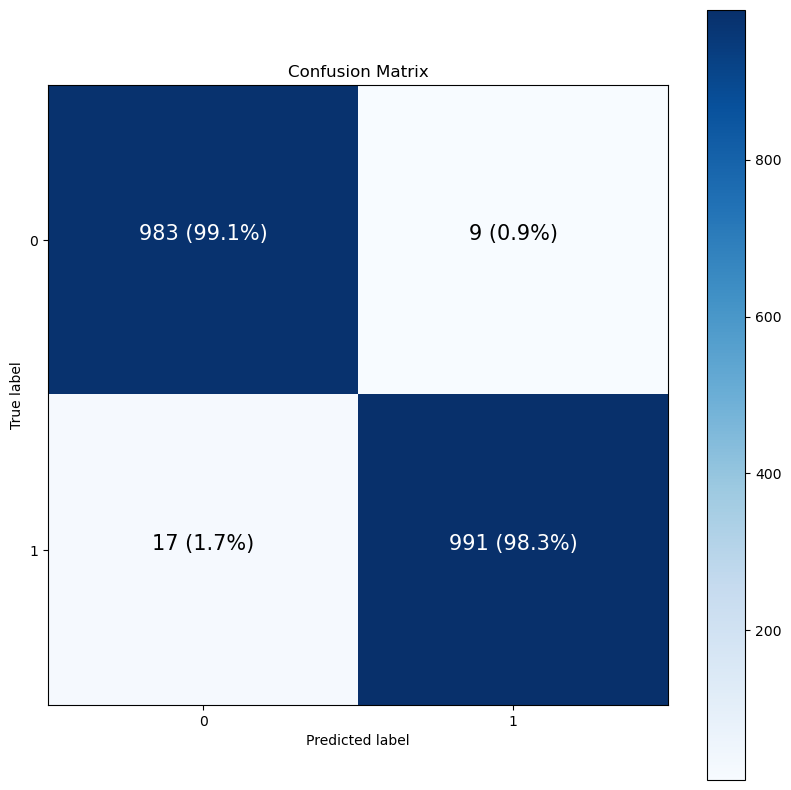

In [14]:
make_confusion_matrix(Y_test, predictions)

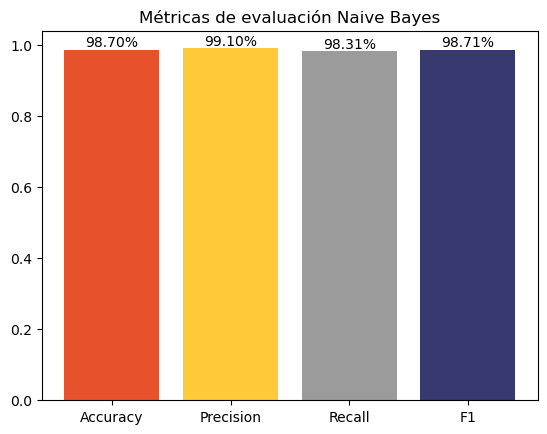

In [15]:
# Creating a list of evaluation metrics
metrics = [accuracy_nb, precision_nb, recall_nb, f1_nb]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

# Create a list of desired colours
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F']

# Create the bar chart
plt.bar(metric_names, metrics, color=colors)
plt.title('Métricas de evaluación Naive Bayes')

# Add text labels above each bar
for i, metric in enumerate(metrics):
    plt.text(i, metric, f'{metric:.2%}', ha = 'center', va = 'bottom')

plt.show()

In [18]:
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_multinomialnb__alpha','param_tfidfvectorizer__min_df', 'mean_test_score']]
results.columns = ['alpha', 'min_df','precision']
results

,alpha,min_df,precision
0,0.001,0.0,0.986889
1,0.001,1,0.986889
2,0.001,5,0.981994
3,0.001,10,0.980027
4,0.001,20,0.978209
...,...,...,...
112,100,20,0.981875
113,100,35,0.980243
114,100,100,0.974416
115,100,150,0.968522


## 2.XGBoost

In [9]:
# Define los parámetros del modelo XGBoost
parameters = {
    'tfidfvectorizer__min_df': [0.0],
    'xgbclassifier__learning_rate': [0.3, 0.4, 0.5],
    'xgbclassifier__max_depth': [16,17, 18],
    'xgbclassifier__subsample': [0.8, 0.9, 1.0],
    'xgbclassifier__colsample_bytree': [0.5,0.6, 0.7]
}

# Create the pipeline with the necessary steps
vec = TfidfVectorizer()
xgb_model = XGBClassifier()
clf = make_pipeline(vec, xgb_model)

# Perform grid search
grid_search = GridSearchCV(clf,parameters, cv=5, scoring='precision', n_jobs=-1, verbose = 1)#try recall or precision instead of accuracy
grid_search.fit(X_train, Y_train)

# Get grid search results
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print('The best accuracy found is from: ', best_score)
print('It is obtained with the hyperparameters: ',best_params)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
La mejor accuracy encontrada es de:  0.9764413448370142
Se obtiene con los hiperparametros:  {'tfidfvectorizer__min_df': 0.0, 'xgbclassifier__colsample_bytree': 0.5, 'xgbclassifier__learning_rate': 0.4, 'xgbclassifier__max_depth': 18, 'xgbclassifier__subsample': 0.9}


In [10]:
# Fit the model with the best parameters found.
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, Y_train)

# Making predictions in the test database
predictions = best_clf.predict(X_test)

# Calculate evaluation metrics in forecasts
accuracy_xgb = accuracy_score(Y_test, predictions)
precision_xgb = precision_score(Y_test, predictions)
recall_xgb = recall_score(Y_test, predictions)
f1_xgb = f1_score(Y_test, predictions)

# Print evaluation metrics
print("Accuracy:", accuracy_xgb)
print("Precision:", precision_xgb)
print("Recall:", recall_xgb)
print("F1-Score:", f1_xgb)

Accuracy: 0.985
Precision: 0.983201581027668
Recall: 0.9871031746031746
F1-Score: 0.9851485148514852


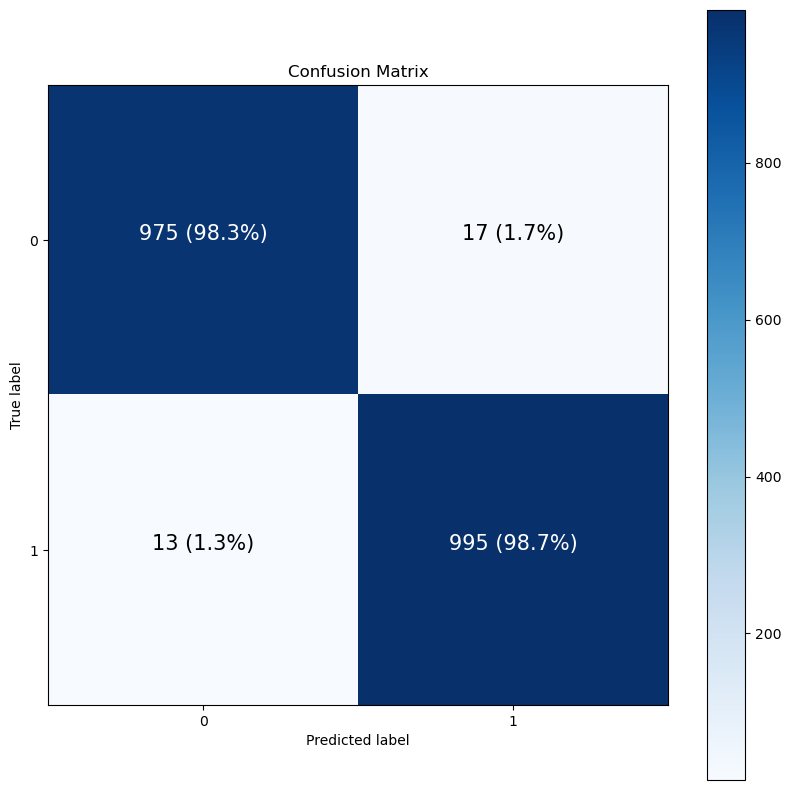

In [11]:
make_confusion_matrix(Y_test, predictions)

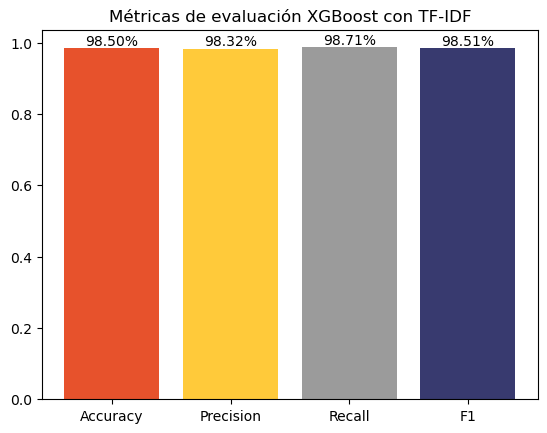

In [14]:
# Creating a list of evaluation metrics
metrics = [accuracy_xgb, precision_xgb, recall_xgb, f1_xgb]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

# Create a list of desired colours
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F']

# Create the bar chart
plt.bar(metric_names, metrics, color=colors)
plt.title('Métricas de evaluación XGBoost con TF-IDF')

# Add text labels above each bar
for i, metric in enumerate(metrics):
    plt.text(i, metric, f'{metric:.2%}', ha='center', va='bottom')

plt.show()

In [12]:
results2 = pd.DataFrame(grid_search.cv_results_)
results2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_tfidfvectorizer__min_df,param_xgbclassifier__colsample_bytree,param_xgbclassifier__learning_rate,param_xgbclassifier__max_depth,param_xgbclassifier__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,51.337335,2.381934,0.565911,0.021211,0.0,0.5,0.3,16,0.8,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.974186,0.976342,0.974925,0.974840,0.975573,0.975173,0.000731,33
1,54.934702,0.847617,0.560858,0.019920,0.0,0.5,0.3,16,0.9,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.973763,0.973398,0.974570,0.973408,0.976334,0.974295,0.001105,67
2,56.588619,1.742022,0.571256,0.047947,0.0,0.5,0.3,16,1.0,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.974484,0.974157,0.975309,0.971589,0.976334,0.974374,0.001583,64
3,51.867376,1.485702,0.544131,0.012239,0.0,0.5,0.3,17,0.8,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.975207,0.974850,0.977085,0.974426,0.977007,0.975715,0.001115,12
4,54.883422,1.092739,0.552358,0.021461,0.0,0.5,0.3,17,0.9,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.974109,0.975967,0.975628,0.974070,0.974522,0.974859,0.000790,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,68.173279,2.227736,0.572683,0.007335,0.0,0.7,0.5,17,0.9,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.976586,0.975151,0.974831,0.971931,0.975867,0.974873,0.001591,50
77,68.774316,0.695720,0.568030,0.012897,0.0,0.7,0.5,17,1.0,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.975536,0.974474,0.974888,0.974021,0.977736,0.975331,0.001302,26
78,66.626266,0.341092,0.545826,0.054938,0.0,0.7,0.5,18,0.8,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.975913,0.972953,0.974503,0.974070,0.974060,0.974300,0.000956,66
79,64.928471,2.676777,0.371893,0.068061,0.0,0.7,0.5,18,0.9,"{'tfidfvectorizer__min_df': 0.0, 'xgbclassifie...",0.974803,0.974774,0.975610,0.972983,0.977367,0.975107,0.001420,40


In [17]:
results2 = pd.DataFrame(grid_search.cv_results_)
results2 = results2[['param_tfidfvectorizer__min_df','param_xgbclassifier__colsample_bytree',
                     'param_xgbclassifier__learning_rate', 'param_xgbclassifier__max_depth',
                     'param_xgbclassifier__subsample','mean_test_score']]
results2.columns = ['min_df','colsample_bytree','learning_rate','max_depth','subsample','precision']
results2

,min_df,colsample_bytree,learning_rate,max_depth,subsample,precision
0,0.0,0.5,0.3,16,0.8,0.975173
1,0.0,0.5,0.3,16,0.9,0.974295
2,0.0,0.5,0.3,16,1.0,0.974374
3,0.0,0.5,0.3,17,0.8,0.975715
4,0.0,0.5,0.3,17,0.9,0.974859
...,...,...,...,...,...,...
76,0.0,0.7,0.5,17,0.9,0.974873
77,0.0,0.7,0.5,17,1.0,0.975331
78,0.0,0.7,0.5,18,0.8,0.974300
79,0.0,0.7,0.5,18,0.9,0.975107


In [50]:
results2.iloc[25,:]

min_df                   0.0
colsample_bytree         0.5
learning_rate            0.5
max_depth                 18
subsample                0.9
precision           0.975555
Name: 25, dtype: object

In [52]:
results2.iloc[37,:]

min_df                   0.0
colsample_bytree         0.6
learning_rate            0.4
max_depth                 16
subsample                0.9
precision           0.975788
Name: 37, dtype: object

# MODELS WITH GLOVE

In [31]:
from gensim.models import KeyedVectors  # to save and load vectors

In [32]:
word2vec_output_file = 'glove_w2v.txt'
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary = False)

In [33]:
#we create a Vectorizer object that will help us to transform our reviews to vectors, a numerical representation. 
#Then we can use those vectors to feed our classifier.

vectorizer = Word2VecVectorizer(word_vectors)

xtrain = vectorizer.fit_transform(X_train)
ytrain = Y_train

xtest = vectorizer.transform(X_test)
ytest = Y_test

Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 11 / 27398
Number of samples with no words found: 0 / 2000


## 1. XGBOOST

In [34]:
# Define the parameters to tune
parameters = {
    'learning_rate': [0.2, 0.3, 0.4],
    'max_depth': [15,16, 17],
    'subsample': [0.4, 0.5, 0.6],
    'colsample_bytree': [0.5, 0.6, 0.7]
}

# Creates the XGBoost model
xgb_model = XGBClassifier()

grid_search = GridSearchCV(xgb_model, parameters, cv = 5, n_jobs = -1,scoring = 'precision',verbose = 1)
grid_search.fit(xtrain, ytrain)

# Gets the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Better parameters:", best_params)
print("Best score:", best_score)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Mejores parámetros: {'colsample_bytree': 0.6, 'learning_rate': 0.3, 'max_depth': 16, 'subsample': 0.5}
Mejor puntaje: 0.9670512479342781


In [35]:
# Fit the model with the best parameters found.
best_clf = grid_search.best_estimator_
best_clf.fit(xtrain, ytrain)

# Making predictions in the test database
test_predictions = best_clf.predict(xtest)

# Calculate evaluation metrics in forecasts
accuracy_xgb_glove = accuracy_score(ytest, test_predictions)
precision_xgb_glove = precision_score(ytest, test_predictions)
recall_xgb_glove = recall_score(ytest, test_predictions)
f1_xgb_glove = f1_score(ytest, test_predictions)

# Print evaluation metrics
print("Accuracy:", accuracy_xgb_glove)
print("Precision:", precision_xgb_glove)
print("Recall:", recall_xgb_glove)
print("F1-Score:", f1_xgb_glove)

Accuracy: 0.973
Precision: 0.9667318982387475
Recall: 0.9801587301587301
F1-Score: 0.9733990147783251


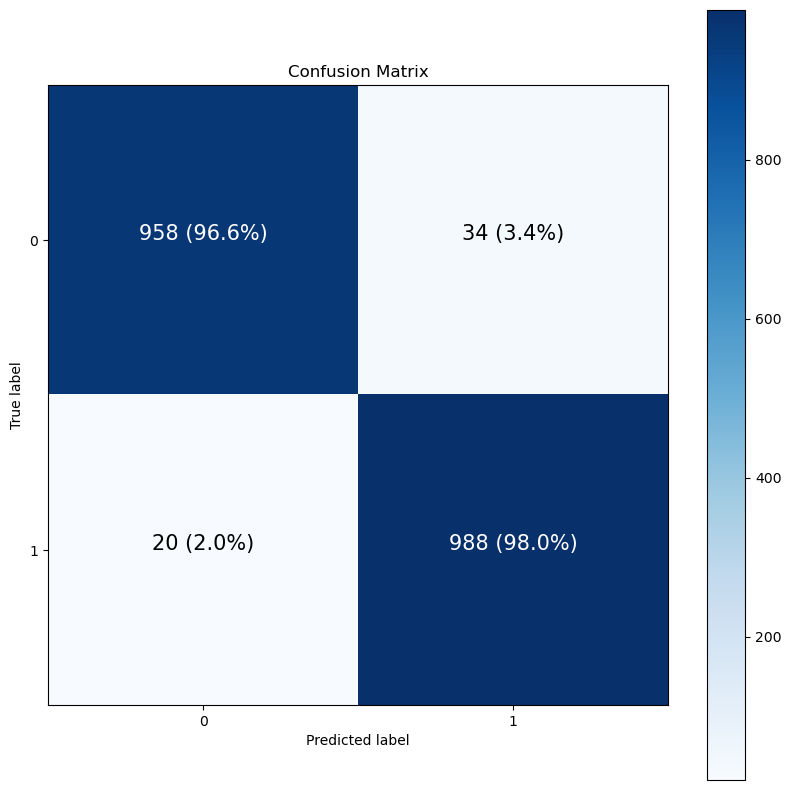

In [36]:
make_confusion_matrix(Y_test, test_predictions)

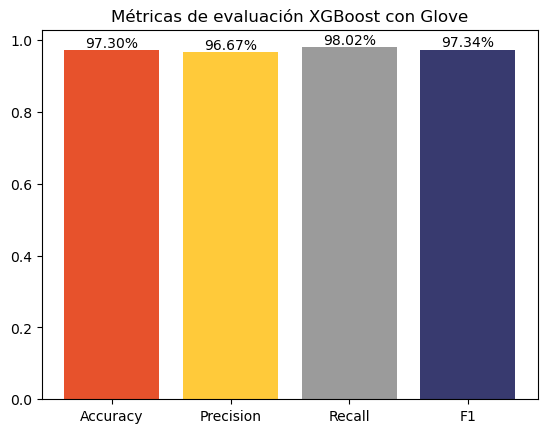

In [29]:
# Creating a list of evaluation metrics
metrics = [accuracy_xgb_glove, precision_xgb_glove, recall_xgb_glove, f1_xgb_glove]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

# Create a list of desired colours
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F']

# Create the bar chart
plt.bar(metric_names, metrics, color=colors)
plt.title('Métricas de evaluación XGBoost con Glove')

# Add text labels above each bar
for i, metric in enumerate(metrics):
    plt.text(i, metric, f'{metric:.2%}', ha='center', va='bottom')

plt.show()

In [30]:
results3 = pd.DataFrame(grid_search.cv_results_)
results3

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,41.689210,0.593665,0.049600,0.001743,0.5,0.2,15,0.4,"{'colsample_bytree': 0.5, 'learning_rate': 0.2...",0.968453,0.959099,0.971429,0.961713,0.965543,0.965248,0.004447,27
1,48.789764,0.574548,0.049200,0.000749,0.5,0.2,15,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.2...",0.964582,0.965283,0.967350,0.960725,0.965922,0.964772,0.002220,43
2,56.087080,1.131429,0.049400,0.001357,0.5,0.2,15,0.6,"{'colsample_bytree': 0.5, 'learning_rate': 0.2...",0.968134,0.966114,0.966428,0.960287,0.966250,0.965443,0.002679,22
3,41.982990,0.914020,0.051424,0.005864,0.5,0.2,16,0.4,"{'colsample_bytree': 0.5, 'learning_rate': 0.2...",0.968061,0.959970,0.966076,0.960681,0.967387,0.964435,0.003423,50
4,49.829785,1.166064,0.051626,0.003254,0.5,0.2,16,0.5,"{'colsample_bytree': 0.5, 'learning_rate': 0.2...",0.965634,0.958021,0.965961,0.965647,0.968024,0.964658,0.003435,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,57.877189,1.662841,0.047601,0.001357,0.7,0.4,16,0.5,"{'colsample_bytree': 0.7, 'learning_rate': 0.4...",0.966275,0.964205,0.962400,0.963341,0.968774,0.964999,0.002281,36
77,64.544120,1.482902,0.043200,0.004445,0.7,0.4,16,0.6,"{'colsample_bytree': 0.7, 'learning_rate': 0.4...",0.969512,0.964218,0.963961,0.963424,0.969084,0.966040,0.002676,7
78,49.452736,0.608601,0.046800,0.000748,0.7,0.4,17,0.4,"{'colsample_bytree': 0.7, 'learning_rate': 0.4...",0.962991,0.961611,0.968809,0.959955,0.964340,0.963541,0.003009,68
79,53.521219,1.687920,0.037600,0.004223,0.7,0.4,17,0.5,"{'colsample_bytree': 0.7, 'learning_rate': 0.4...",0.967350,0.962002,0.963828,0.961103,0.970543,0.964965,0.003516,39


In [35]:
results3 = pd.DataFrame(grid_search.cv_results_)
results3 = results3[['param_colsample_bytree','param_learning_rate', 'param_max_depth','param_subsample','mean_test_score']]
results3.columns = ['colsample_bytree','learning_rate','max_depth','subsample','precision']
results3

,colsample_bytree,learning_rate,max_depth,subsample,precision
0,0.5,0.2,15,0.4,0.965248
1,0.5,0.2,15,0.5,0.964772
2,0.5,0.2,15,0.6,0.965443
3,0.5,0.2,16,0.4,0.964435
4,0.5,0.2,16,0.5,0.964658
...,...,...,...,...,...
76,0.7,0.4,16,0.5,0.964999
77,0.7,0.4,16,0.6,0.966040
78,0.7,0.4,17,0.4,0.963541
79,0.7,0.4,17,0.5,0.964965


In [43]:
results3.iloc[55,:]

colsample_bytree         0.7
learning_rate            0.2
max_depth                 15
subsample                0.5
precision           0.963951
Name: 55, dtype: object

In [47]:
results3.iloc[65,:]

colsample_bytree         0.7
learning_rate            0.3
max_depth                 15
subsample                0.6
precision           0.965662
Name: 65, dtype: object

## 2.LSTM

In [9]:
from gensim.models import KeyedVectors  # to save and load vectors
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

In [10]:
# loading pretrained google news word2vec embedding 300D
word2vec_pretrained = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
word2vec_pretrained_dict = dict(zip(word2vec_pretrained.key_to_index.keys(),
                                    word2vec_pretrained.vectors))

In [11]:
list(word2vec_pretrained_dict.values())[0].shape

(300,)

In [12]:
token = tf.keras.preprocessing.text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test)) # fits tokens into texts
xtrain_seq = token.texts_to_sequences(X_train) # text to sequences converts the words of the sentence into numerical sequences
xtest_seq = token.texts_to_sequences(X_test)

#zero pad sequences
xtrain_pad = pad_sequences(xtrain_seq,padding='post') # zero-fill all sentences to have the same shape as the largest one.
xtest_pad = pad_sequences(xtest_seq,padding='post')

word_index = token.word_index # returns the index of words that have been tokenised

In [13]:
ytrain = Y_train
ytest = Y_test

In [14]:
#create embedding matrix for words that we have in dataset

embedding_matrix = np.zeros((len(word_index)+1, 300))
for word,i in word_index.items():
    embedding_vector = word2vec_pretrained_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [15]:
model_bi = Sequential()
model_bi.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable = False))

model_bi.add(SpatialDropout1D(0.3))
model_bi.add(Bidirectional(LSTM(150, dropout = 0.3, recurrent_dropout = 0.3)))

model_bi.add(Dense(1024, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(1024, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(1))
model_bi.add(Activation('sigmoid'))
model_bi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         36621900  
                                                                 
 spatial_dropout1d (SpatialD  (None, None, 300)        0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 300)              541200    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1024)              308224    
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1

In [16]:
model_bi.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 1,
                          mode = 'auto')

history_bi = model_bi.fit(xtrain_pad, y = Y_train, batch_size = 128, epochs = 100, 
                       verbose = 1, validation_data = (xtest_pad, Y_test),callbacks = [earlystop])

Epoch 1/100
215/215 [==============================] - 1368s 6s/step - loss: 0.2399 - accuracy: 0.8978 - val_loss: 0.1460 - val_accuracy: 0.9505
Epoch 2/100
215/215 [==============================] - 1352s 6s/step - loss: 0.1589 - accuracy: 0.9433 - val_loss: 0.1034 - val_accuracy: 0.9595
Epoch 3/100
215/215 [==============================] - 1355s 6s/step - loss: 0.1231 - accuracy: 0.9548 - val_loss: 0.0871 - val_accuracy: 0.9715
Epoch 4/100
215/215 [==============================] - 1359s 6s/step - loss: 0.1186 - accuracy: 0.9569 - val_loss: 0.1206 - val_accuracy: 0.9515
Epoch 5/100
215/215 [==============================] - 1348s 6s/step - loss: 0.0954 - accuracy: 0.9662 - val_loss: 0.0928 - val_accuracy: 0.9710
Epoch 5: early stopping


In [17]:
y_pred = model_bi.predict(xtest_pad)

63/63 [==============================] - 443s 7s/step


In [18]:
predictions3 = np.round(y_pred)
predictions3

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [19]:
# Calculate evaluation metrics in forecasts
accuracy_LSTM = accuracy_score(ytest, predictions3)
precision_LSTM = precision_score(ytest, predictions3)
recall_LSTM = recall_score(ytest, predictions3)
f1_LSTM = f1_score(ytest, predictions3)

# Print evaluation metrics
print("Accuracy:", accuracy_LSTM)
print("Precision:", precision_LSTM)
print("Recall:", recall_LSTM)
print("F1-Score:", f1_LSTM)

Accuracy: 0.971
Precision: 0.975
Recall: 0.9672619047619048
F1-Score: 0.9711155378486055


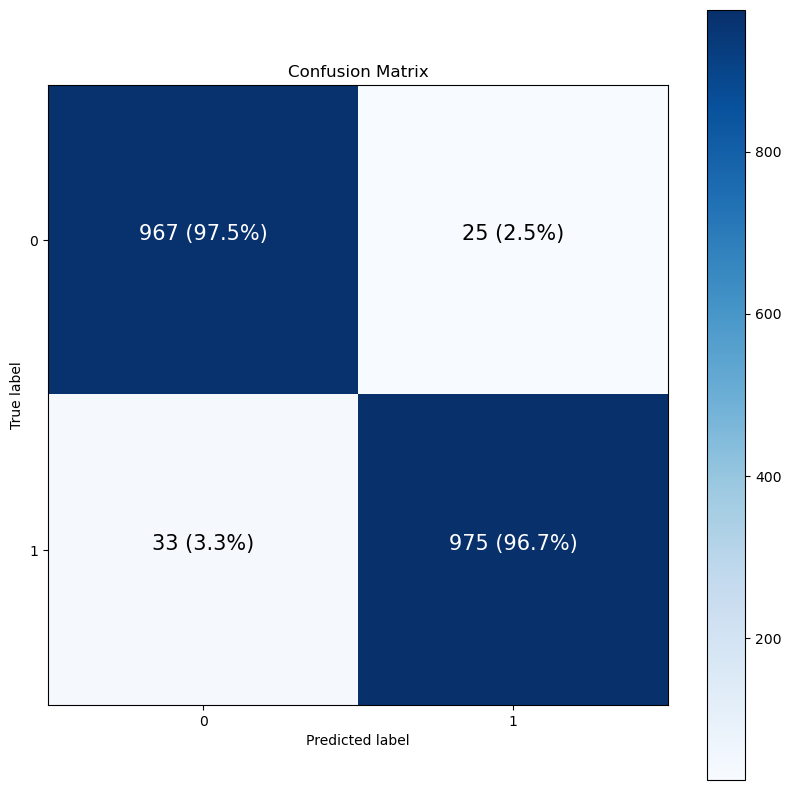

In [20]:
make_confusion_matrix(Y_test, predictions3)

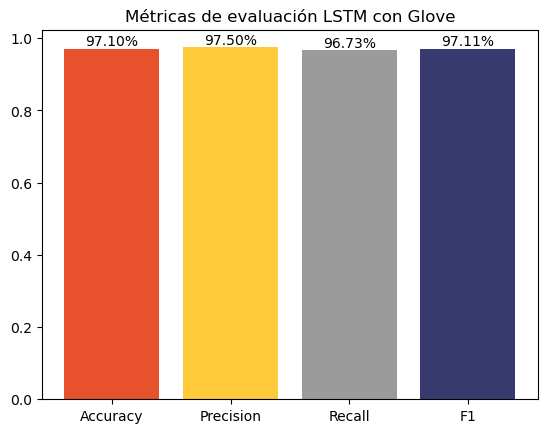

In [21]:
# Creating a list of evaluation metrics
metrics = [accuracy_LSTM, precision_LSTM, recall_LSTM, f1_LSTM]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

# Create a list of desired colours
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F']

# Create the bar chart
plt.bar(metric_names, metrics, color=colors)
plt.title('Métricas de evaluación LSTM con Glove')

# Add text labels above each bar
for i, metric in enumerate(metrics):
    plt.text(i, metric, f'{metric:.2%}', ha='center', va='bottom')

plt.show()

## ANOTHER LSTM

In [9]:
from gensim.models import KeyedVectors  
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

In [10]:
# loading pretrained google news word2vec embedding 300D
word2vec_pretrained = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin", binary=True)
word2vec_pretrained_dict = dict(zip(word2vec_pretrained.key_to_index.keys(),
                                    word2vec_pretrained.vectors))

In [11]:
token = tf.keras.preprocessing.text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test))
xtrain_seq = token.texts_to_sequences(X_train) 
xtest_seq = token.texts_to_sequences(X_test)

#zero pad sequences
xtrain_pad = pad_sequences(xtrain_seq,padding='post') 
xtest_pad = pad_sequences(xtest_seq,padding='post')

word_index = token.word_index 

In [12]:
ytrain = Y_train
ytest = Y_test

In [13]:
#create embedding matrix for words that we have in dataset

embedding_matrix = np.zeros((len(word_index)+1, 300))
for word,i in word_index.items():
    embedding_vector = word2vec_pretrained_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [16]:
model_bi = Sequential()
model_bi.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable = False))

model_bi.add(SpatialDropout1D(0.3))
model_bi.add(Bidirectional(LSTM(150, dropout = 0.3, recurrent_dropout = 0.3)))

model_bi.add(Dense(512, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(512, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(1))
model_bi.add(Activation('sigmoid'))
model_bi.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         36621900  
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 300)        0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              541200    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 512)               154112    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [17]:
model_bi.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 2, verbose = 1,
                          mode = 'auto')

history_bi = model_bi.fit(xtrain_pad, y = Y_train, batch_size = 128, epochs = 100, 
                       verbose = 1, validation_data = (xtest_pad, Y_test),callbacks = [earlystop])

Epoch 1/100
215/215 [==============================] - 1395s 6s/step - loss: 0.2558 - accuracy: 0.8920 - val_loss: 0.1290 - val_accuracy: 0.9510
Epoch 2/100
215/215 [==============================] - 1379s 6s/step - loss: 0.1548 - accuracy: 0.9442 - val_loss: 0.1228 - val_accuracy: 0.9560
Epoch 3/100
215/215 [==============================] - 1355s 6s/step - loss: 0.1241 - accuracy: 0.9551 - val_loss: 0.1076 - val_accuracy: 0.9655
Epoch 4/100
215/215 [==============================] - 1391s 6s/step - loss: 0.1090 - accuracy: 0.9616 - val_loss: 0.0783 - val_accuracy: 0.9720
Epoch 5/100
215/215 [==============================] - 1387s 6s/step - loss: 0.0938 - accuracy: 0.9676 - val_loss: 0.0797 - val_accuracy: 0.9705
Epoch 6/100
215/215 [==============================] - 1393s 6s/step - loss: 0.0846 - accuracy: 0.9705 - val_loss: 0.0683 - val_accuracy: 0.9790
Epoch 7/100
215/215 [==============================] - 1379s 6s/step - loss: 0.0749 - accuracy: 0.9745 - val_loss: 0.0808 - val_ac

In [18]:
y_pred = model_bi.predict(xtest_pad)

63/63 [==============================] - 435s 7s/step


In [19]:
predictions3 = np.round(y_pred)
predictions3

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [20]:
# Calculate evaluation metrics in forecasts
accuracy_LSTM = accuracy_score(ytest, predictions3)
precision_LSTM = precision_score(ytest, predictions3)
recall_LSTM = recall_score(ytest, predictions3)
f1_LSTM = f1_score(ytest, predictions3)

# Print evaluation metrics
print("Accuracy:", accuracy_LSTM)
print("Precision:", precision_LSTM)
print("Recall:", recall_LSTM)
print("F1-Score:", f1_LSTM)

Accuracy: 0.9825
Precision: 0.9840796019900497
Recall: 0.9811507936507936
F1-Score: 0.9826130153999006


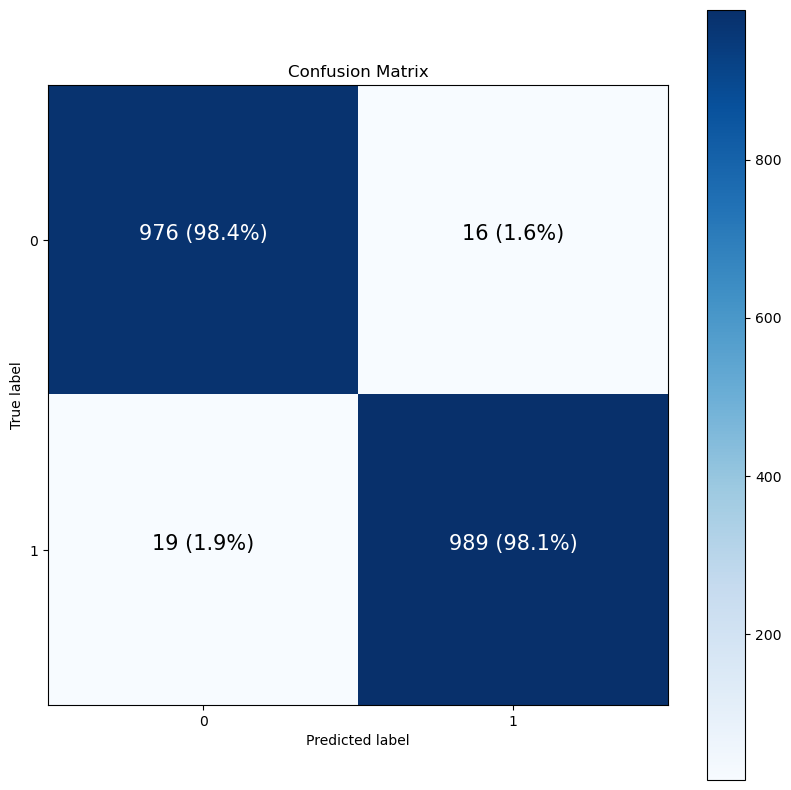

In [21]:
make_confusion_matrix(Y_test, predictions3)

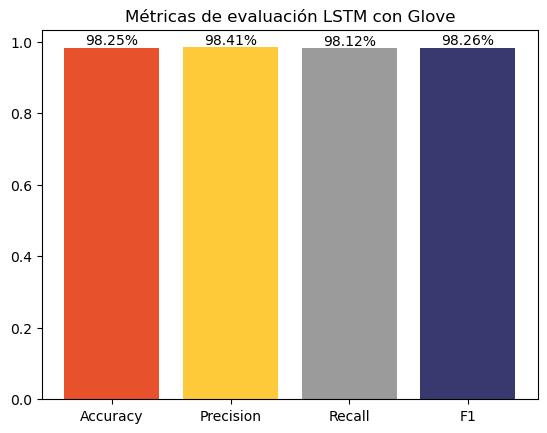

In [22]:
# Creating a list of evaluation metrics
metrics = [accuracy_LSTM, precision_LSTM, recall_LSTM, f1_LSTM]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

# Create a list of desired colours
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F']

# Create the bar chart
plt.bar(metric_names, metrics, color=colors)
plt.title('Métricas de evaluación LSTM con Glove')

# Add text labels above each bar
for i, metric in enumerate(metrics):
    plt.text(i, metric, f'{metric:.2%}', ha='center', va='bottom')

plt.show()

### LSTM WITHOUT GLOVE

In [15]:
# Tokenises texts and converts words into number sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['text_clean'])

train_sequences = tokenizer.texts_to_sequences(train['text_clean'])
test_sequences = tokenizer.texts_to_sequences(test['text_clean'])

# Limits the length of the sequences to the maximum number of words allowed.
max_sequence_length = 100
train_sequences = pad_sequences(train_sequences, maxlen = max_sequence_length)
test_sequences = pad_sequences(test_sequences, maxlen = max_sequence_length)

# Create the LSTM model
embedding_dim = 100

model = Sequential()
model.add(Embedding(input_dim = len(tokenizer.word_index) + 1, output_dim = embedding_dim, 
                    input_length = max_sequence_length))
model.add(LSTM(units=100))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model

model.fit(train_sequences, train['label'], batch_size=64, epochs=10,
          validation_data=(test_sequences, test['label']))

Epoch 1/10
429/429 [==============================] - 69s 157ms/step - loss: 0.1137 - accuracy: 0.9593 - val_loss: 0.0472 - val_accuracy: 0.9860
Epoch 2/10
429/429 [==============================] - 70s 164ms/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.0392 - val_accuracy: 0.9865
Epoch 3/10
429/429 [==============================] - 69s 161ms/step - loss: 0.0049 - accuracy: 0.9988 - val_loss: 0.0690 - val_accuracy: 0.9825
Epoch 4/10
429/429 [==============================] - 71s 165ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0635 - val_accuracy: 0.9860
Epoch 5/10
429/429 [==============================] - 70s 163ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0428 - val_accuracy: 0.9895
Epoch 6/10
429/429 [==============================] - 70s 162ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0539 - val_accuracy: 0.9885
Epoch 7/10
429/429 [==============================] - 69s 162ms/step - loss: 0.0026 - accuracy: 0.9993 - val_loss: 0.0750 - val_ac

In [16]:
# Make predictions on the test set
predictions = model.predict(test_sequences)
predicted_classes = np.where(predictions >= 0.5, 1, 0)

# Calculates and displays evaluation metrics
accuracy_LSTM2 = accuracy_score(test['label'], predicted_classes)
precision_LSTM2 = precision_score(test['label'], predicted_classes)
recall_LSTM2 = recall_score(test['label'], predicted_classes)
f1_LSTM2 = f1_score(test['label'], predicted_classes)

print("Exactitud:", accuracy_LSTM2)
print("Precisión:", precision_LSTM2)
print("Recall:", recall_LSTM2)
print("Puntuacion f1:", f1_LSTM2)

63/63 [==============================] - 1s 12ms/step
Exactitud: 0.9895
Precisión: 0.9881305637982196
Recall: 0.9910714285714286
Puntuación F1: 0.9895988112927192


In [ ]:
make_confusion_matrix(test['label'], predicted_classes)

In [ ]:
# Creating a list of evaluation metrics
metrics = [accuracy_LSTM2, precision_LSTM2, recall_LSTM2, f1_LSTM2]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

# Create a list of desired colours
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F']

# Create the bar chart
plt.bar(metric_names, metrics, color=colors)
plt.title('Métricas de evaluación BERT')

# Add text labels above each bar
for i, metric in enumerate(metrics):
    plt.text(i, metric, f'{metric:.2%}', ha='center', va='bottom')

plt.show()

# BERT 

In [3]:
train = pd.read_csv('train_pre.csv')
test = pd.read_csv('test_pre.csv')

In [4]:
# Check for NaN values
if any(train.isna()):
    train = train.dropna() # Delete rows with NaN values
    train = train.astype(str) # Convert all values to strings
    print("train contains NaN values")

# Check for non-string values
if not all(isinstance(x, str) for x in train):
    print("train contains non-string values")

train contains NaN values


In [5]:
# Check for NaN values
if any(test.isna()):
    train = train.dropna() 
    train = train.astype(str) 
    print("test contains NaN values")

# Check for non-string values
if not all(isinstance(x, str) for x in test):
    print("test contains non-string values")

test contains NaN values


In [6]:
X_train = train['text_clean']
Y_train = train['label']

X_test = test['text_clean']
Y_test = test['label']

In [7]:
# Hugging Face Transformers
from transformers import (pipeline , BertTokenizer,
                          TFBertForSequenceClassification,
                          InputExample, InputFeatures , 
                         AutoTokenizer, TFAutoModelForSequenceClassification )

In [8]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Define the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate = 2e-5, epsilon = 1e-08)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']

In [11]:
# Define the model inputs and outputs
input_ids = tf.keras.layers.Input(shape = (98,), dtype = tf.int32, name = 'input_ids')
attention_mask = tf.keras.layers.Input(shape = (98,), dtype = tf.int32, name = 'attention_mask')
output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]

# Add a dense layer with sigmoid activation for binary classification
output = tf.keras.layers.Dense(1, activation='sigmoid')(output)

In [12]:
# Define the model
model_bert = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
model_bert.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [14]:
# Define the training and validation datasets

def datasets(tokenizer):
    
    # Tokenize the input sequences and convert to input IDs and attention masks
    train_encodings = tokenizer(list(X_train.values), truncation=True, padding=True,max_length=98)
    
    train_labels = tf.convert_to_tensor(Y_train, dtype=tf.float32)
    train_labels = tf.reshape(train_labels, (-1, 1))
    train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_encodings['input_ids'],
                    'attention_mask': train_encodings['attention_mask']}, train_labels))
    
    val_encodings = tokenizer(list(X_test.values), truncation=True, padding=True,max_length=98)
    val_labels = tf.convert_to_tensor(Y_test, dtype=tf.float32)
    val_labels = tf.reshape(val_labels, (-1, 1))
    val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_encodings['input_ids'],
                    'attention_mask': val_encodings['attention_mask']}, val_labels))
    
    
    # Batch and shuffle the datasets
    batch_size = 32
    train_dataset = train_dataset.batch(batch_size).shuffle(1000)
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset,val_dataset

In [15]:
# Define the training and validation datasets
train_dataset, val_dataset = datasets(tokenizer)

In [27]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the reduce LR on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor='val_accuracy',
    mode='max',
    factor=0.25,
    patience=1,
    min_lr=1e-6)

# Define the early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=2,
    restore_best_weights=True)

In [28]:
# Train the model for a few epochs
history_bert = model_bert.fit(train_dataset, validation_data=val_dataset, epochs=10,
                              callbacks=[early_stopping_callback, reduce_lr_callback])

Epoch 1/10
856/856 [==============================] - 444s 518ms/step - loss: 8.3302e-04 - accuracy: 0.9998 - val_loss: 0.0446 - val_accuracy: 0.9920 - lr: 1.0000e-06
Epoch 2/10
856/856 [==============================] - 443s 518ms/step - loss: 3.4552e-04 - accuracy: 0.9999 - val_loss: 0.0482 - val_accuracy: 0.9920 - lr: 1.0000e-06
Epoch 3/10
856/856 [==============================] - 443s 518ms/step - loss: 2.4250e-04 - accuracy: 1.0000 - val_loss: 0.0500 - val_accuracy: 0.9925 - lr: 1.0000e-06
Epoch 4/10
856/856 [==============================] - 443s 517ms/step - loss: 1.0364e-04 - accuracy: 1.0000 - val_loss: 0.0523 - val_accuracy: 0.9925 - lr: 1.0000e-06
Epoch 5/10
856/856 [==============================] - 443s 518ms/step - loss: 1.4187e-04 - accuracy: 1.0000 - val_loss: 0.0553 - val_accuracy: 0.9925 - lr: 1.0000e-06


In [29]:
# Make predictions on the test dataset
predictions = model_bert.predict(val_dataset)
predictions = np.round(predictions)

63/63 [==============================] - 11s 169ms/step


In [30]:
# Calculate evaluation metrics in forecasts
accuracy_bert = accuracy_score(Y_test, predictions)
precision_bert = precision_score(Y_test, predictions)
recall_bert = recall_score(Y_test, predictions)
f1_bert = f1_score(Y_test, predictions)

# Print evaluation metrics
print("Accuracy:", accuracy_bert)
print("Precision:", precision_bert)
print("Recall:", recall_bert)
print("F1-Score:", f1_bert)

Accuracy: 0.9925
Precision: 0.9940298507462687
Recall: 0.9910714285714286
F1-Score: 0.9925484351713861


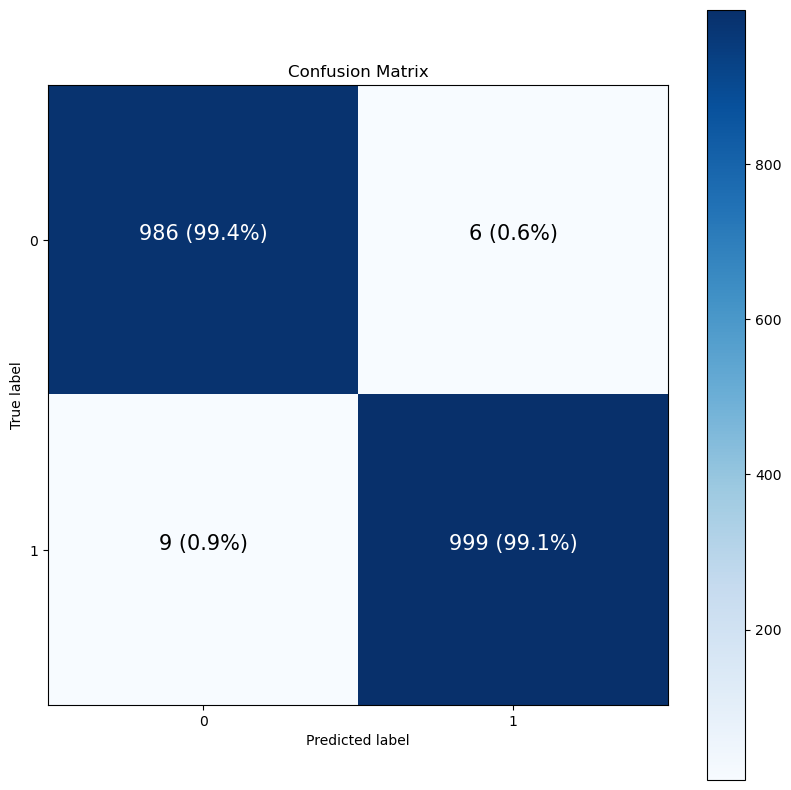

In [31]:
make_confusion_matrix(Y_test, predictions)

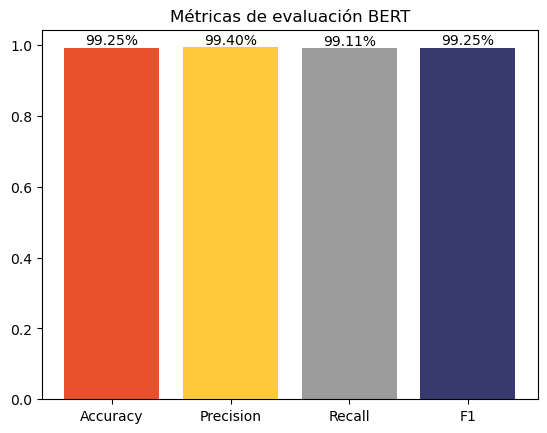

In [32]:
# Creating a list of evaluation metrics
metrics = [accuracy_bert, precision_bert, recall_bert, f1_bert]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']

# Create a list of desired colours
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F']

# Create the bar chart
plt.bar(metric_names, metrics, color=colors)
plt.title('Métricas de evaluación BERT')

# Add text labels above each bar
for i, metric in enumerate(metrics):
    plt.text(i, metric, f'{metric:.2%}', ha='center', va='bottom')

plt.show()

# RESULTS 

In [66]:
NB = [98.7, 99.1, 98.31, 98.71]
XGBT = [98.5, 98.32, 98.71, 98.51]
XGBG = [97.3, 96.67, 98.02, 97.34]
LSTMBi = [98.25, 98.41, 98.12, 98.26]
BERT = [99.25, 99.4, 99.11, 99.25]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1']
modelos = ['NB', 'XGB + TF-IDF', 'XGB + Glove','BiLSTM','BERT']

data = [NB, XGBT, XGBG, LSTMBi, BERT]
df = pd.DataFrame(data, index=modelos, columns=metric_names)

In [67]:
df

,Accuracy,Precision,Recall,F1
NB,98.70,99.10,98.31,98.71
XGB + TF-IDF,98.50,98.32,98.71,98.51
XGB + Glove,97.30,96.67,98.02,97.34
BiLSTM,98.25,98.41,98.12,98.26
BERT,99.25,99.40,99.11,99.25


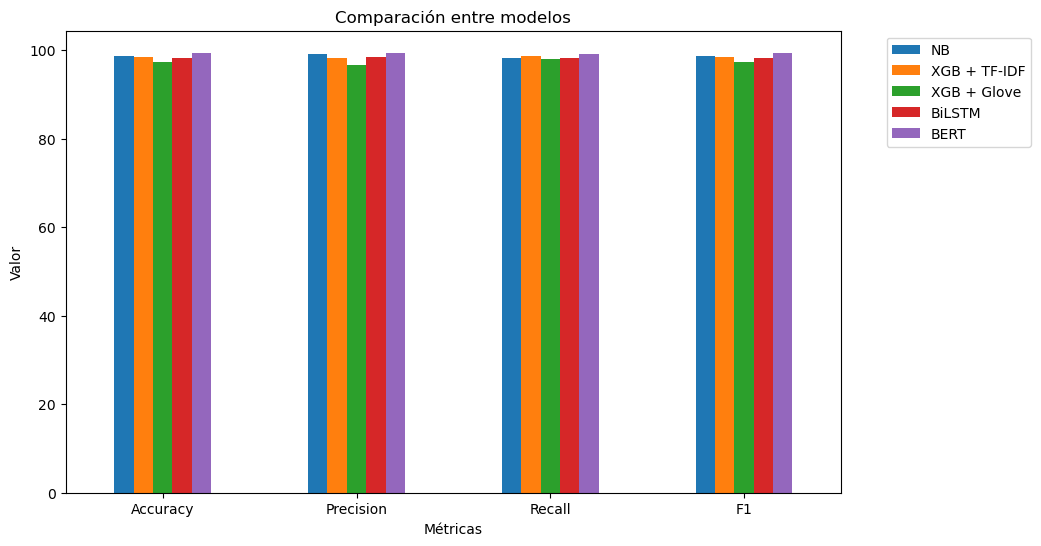

In [68]:
import matplotlib.pyplot as plt

# We transpose the data frame so that the models are the columns and the metrics are the rows.
df_T = df.T

# We create a bar chart with the transposed data frame data.
ax = df_T.plot(kind = 'bar', figsize = (10, 6), rot = 0)

# Add labels to the axes and a title to the chart
ax.set_xlabel('Metrics')
ax.set_ylabel('Value')
ax.set_title('Comparison between models')

# We move the legend out of the chart
ax.legend(bbox_to_anchor = (1.05, 1.0), loc = 'upper left')

# We show the graph
plt.show()

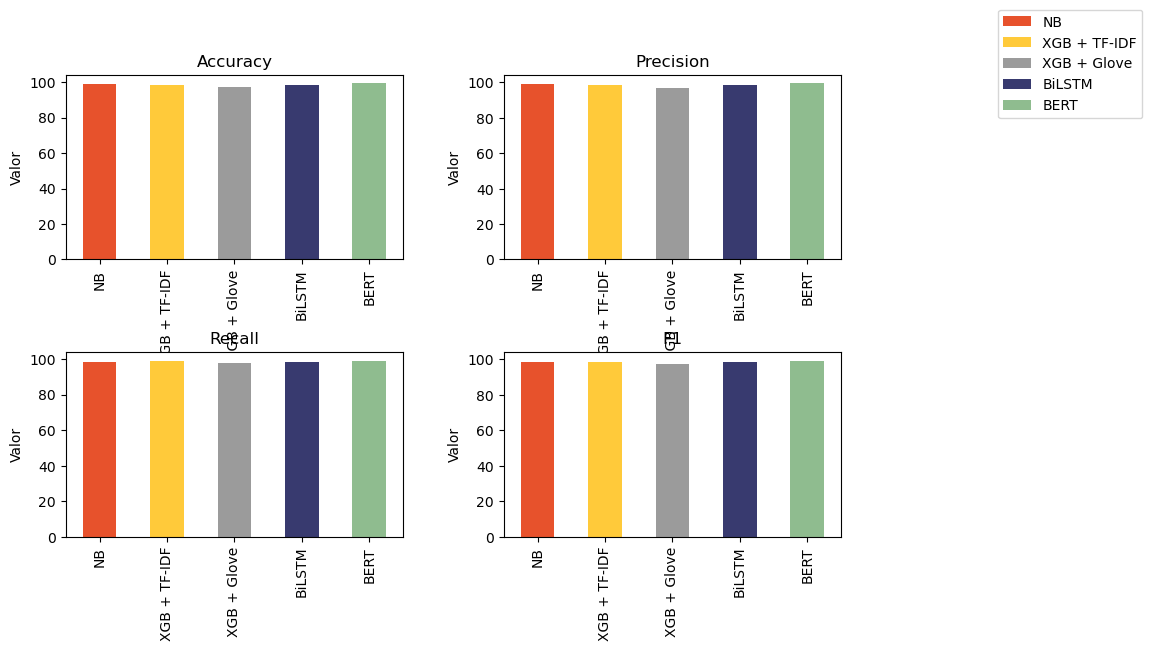

In [71]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# We transpose the data frame so that the models are the columns and the metrics are the rows.
df_T = df.T

# We create a figure with several subgraphs in a 2x2 layout.
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))

# We define a list of colours for each model
colors = ['#E7522C', '#FFCA3A','#9B9B9B','#383A6F', '#8FBC8F']

# We go through each metric and create a bar chart for each one.
for i, metric in enumerate(df_T.index):
    # We order the values of the metric from highest to lowest
    data = df_T.loc[metric]
    
    # Calculate the position of the subgraph in the subgraph matrix
    row = i // 2
    col = i % 2
    
    # We create a bar chart with the data sorted in the corresponding sub-chart
    ax = data.plot(kind='bar', ax=axes[row, col], rot=0, color=colors)
    
    # We show the names of the models on the x-axis written vertically.
    ax.set_xticklabels(data.index, rotation=90)
    
    # Add labels to the axes and a title to the chart
    ax.set_xlabel('')
    ax.set_ylabel('Valor')
    ax.set_title(metric)

# We create a list of Patch objects for each model with the corresponding colour.
legend_elements = [Patch(facecolor=color, label=model) for color, model in zip(colors, df_T.columns)]

# We add a legend with the colour of each model to the figure.
fig.legend(handles = legend_elements, bbox_to_anchor=(1.05, 1.0), loc='upper left')

# We adjust the spacing between the subcharts
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# We show the graph
plt.show()